In [126]:
import numpy as np
from ExtendedTSSRP import ExtendedTSSRP
from MSSRP import MSSRP
from TSSRP import TSSRP
from spc.spc import spc
import time
nmodels = 3
model_all = [[] for i in range(nmodels)]
model_name = ['E_srp_T2','E_srp_T1_Max','srp_M']

# Solar 

In [127]:
import scipy.io as io
import matplotlib.pyplot as plt
import numpy as np
data = io.loadmat('data/solar.mat')
X_org_1 = data['data']

In [128]:
T0 = 200
dX = np.diff(X_org_1,n=1,axis=-1)
mdX = np.mean(dX[:,:,:T0],axis=-1)

X1 = dX - mdX[:,:,np.newaxis]
X2 = X1/np.std(X1)
X = np.rollaxis(X2,2,0)
X_org = np.rollaxis(X_org_1, 2,0)
nt,nx,ny = X.shape


In [129]:
from Bspline import bsplineBasis

In [130]:
p = nx*ny # Number of dimensions
c = 1 # Target meanshift is c * M
nsensors = 2000 # Number of selected sensors
Ks = 100   #Select Top Ks control chart
k0 = 40   # Number of knots in bspline, which is related to number of failure mode
k = k0**2
degree = 1 # Overlap region? (Size of B-spline basis) 
Bx = bsplineBasis(nx,k0-degree+1,degree)
By = bsplineBasis(ny,k0-degree+1,degree)
M = np.kron(Bx,By)
k = k0**2 # Number of failuer Mode
nmodels = 4

experiment_log = {'c':c, 'Ks':Ks, 'k0':k0, 'degree':degree,'statistics':[],
                  'sens_history': [],
                  'mode_history':[],
                  'seq_stats': [] }
model_all = [[] for i in range(nmodels)]
model_all[0] = ExtendedTSSRP(p, c, k, M, nsensors, Ks, L=-1, chart = 'srp',mode='T2',decisionchart=1)
model_all[1] = ExtendedTSSRP(p, c, k, M, nsensors, Ks, L=-1, chart = 'srp',mode='T1_Max',decisionchart=1)
model_all[2] = ExtendedTSSRP(p, c, k, M, nsensors, Ks, L=-1, chart = 'srp',mode='T2',decisionchart=10)
model_all[3] = ExtendedTSSRP(p, c, k, M, nsensors, Ks, L=-1, chart = 'srp',mode='T1_Max',decisionchart=10)


In [133]:
for i in range(nmodels):
    sequential_statistics_topRsum, sensor_selection_history, failure_mode_history, i,sequential_statistics= model_all[i].compute_monitoring_statistics(X.reshape((nt,nx*ny)),T0,-1)
    experiment_log['statistics'].append( sequential_statistics_topRsum)
    experiment_log['sens_history'].append(sensor_selection_history)
    experiment_log['mode_history'].append(failure_mode_history)
    experiment_log['seq_stats'].append(sequential_statistics)

KeyboardInterrupt: 

In [ ]:
import pickle
import time
filename = time.strftime("%Y%b%d_%H%M_exp_solar1.pickle", time.localtime())
pickle.dump( experiment_log, open( filename, "wb" ))

# Load results from Log

In [83]:
import pickle
import numpy as np
explog = pickle.load(open('2020Jul19_2015_exp_solar1.pickle',"rb"))
explog

{'c': 1,
 'Ks': 100,
 'k0': 40,
 'degree': 1,
 'statistics': 0,
 'sens_history': array([[45108., 44998., 43328., ..., 47429., 42753., 45946.],
        [43261., 39906., 41291., ..., 40851., 41238., 38578.],
        [36724., 43411., 50516., ..., 49267., 36412., 38796.],
        ...,
        [22768., 29561., 53766., ..., 31204., 37095., 11235.],
        [ 7000., 67542., 24341., ...,  8496.,  4734., 66162.],
        [38049.,  3698.,  8828., ..., 52024., 23221., 40765.]]),
 'mode_history': array([[   0., 1072., 1071., ..., 1025., 1001., 1099.],
        [1039., 1096.,  975., ..., 1203., 1202., 1201.],
        [1203.,  890.,  938., ...,  848.,  849.,  850.],
        ...,
        [1206., 1166., 1205., ...,  165.,  945., 1278.],
        [1166., 1206., 1205., ...,  445., 1019., 1458.],
        [1166., 1206., 1205., ..., 1021., 1215., 1271.]]),
 'seq_stats': array([[ 0.69314718,  0.69314718,  0.69314718, ...,  0.69314718,
          0.69314718,  0.69314718],
        [-2.5088809 , -0.10746857,  1.0

## Monitor Statistics
Tried multiple settings but some has false alarm around 150. 

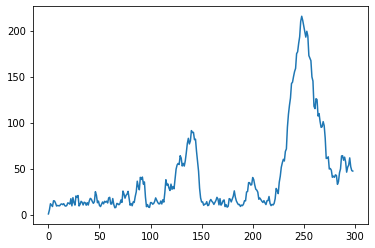

In [84]:
plt.plot(explog['statistics'])
plt.savefig('1.png')

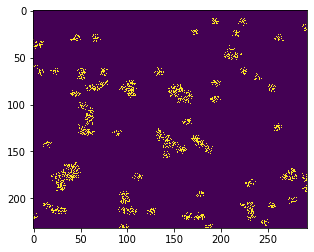

In [101]:
from matplotlib import animation
fig = plt.figure()
isample = 0
ims = []
for t in range(nt):
    sens=np.zeros(nx*ny)
    sens[explog['sens_history'][t].astype(np.int)] = 1
    msens = sens.reshape((nx,ny))
    im = plt.imshow(msens)
    ims.append([im])
ani = animation.ArtistAnimation(fig, ims, interval=50,blit=True,repeat_delay=1000)
ani.save('solar_sensing.mp4')

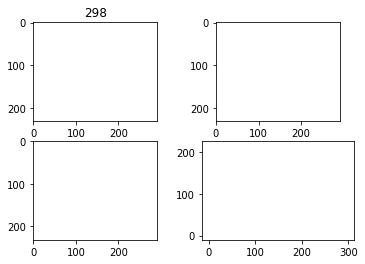

In [108]:
from celluloid import Camera
fig, ax = plt.subplots(2,2)
camera = Camera(fig)

for t in range(nt):
    sens=np.zeros(nx*ny)
    sens[explog['sens_history'][t].astype(np.int)] = 1
    msens = sens.reshape((nx,ny))
    ax[0,0].imshow(X_org[t],cmap=plt.get_cmap('hot'))
    ax[0,0].set_title(str(t))
    ax[0,1].imshow(msens)
    ax[1,0].imshow(X[t],cmap=plt.get_cmap('hot'))
    ax[1,1].plot(explog['statistics'][:t],'k')
    camera.snap()
animation = camera.animate()
animation.save('solar_sensing.mp4')

In [109]:
from IPython.display import Video
Video("solar_sensing.mp4")